In [1]:
dnn_attack_intensity = 9

In [2]:
from models.ae import AE
from models.vae import VAE
from models.rnn import RNN
from models.dnn import DNN
from models.dnnAE import DNN as DNNAE


import torch
import torch.nn.functional as F

from sklearn import metrics

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat
from matplotlib.ticker import FormatStrFormatter

In [3]:
seed = 29
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [5]:
# vae parameter
latent_dim = 118
# rnn parameter
hidden_size = 100
num_layers = 2
rnn_window = 10
# proposed model parameter
samples = 30
# ae parameter
no_residuals = 1

# predictions
pred = defaultdict(dict)
y = defaultdict()
no_signal = defaultdict()

# **DNN Data Generation**

## **Load Sensor and Residual Data**

In [6]:
Z, RES = defaultdict(dict), defaultdict(dict)
for severity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{severity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[severity][att_type] = data['Z']
        RES[severity][att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']

Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


## **Load Trained Models**

In [7]:
noise_levels = [0, 5, 10, 20, 50]
vaes, rnns, aes = dict(), dict(), dict()
# load vae, rnn, ae trained model based on noise levels
for level in noise_levels:
    vae = VAE(latent_dim).to(device, torch.float32)
    vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{level}%.pt')))
    vaes[level] = vae

    rnn = RNN(input_dims=rnn_window * latent_dim,
              outputdims=latent_dim,
              hidden_size=hidden_size,
              num_layers=num_layers).to(device, torch.float32)
    rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'rnn_{level}%.pt')))
    rnns[level] = rnn

    ae = AE(latent_dim).to(device, torch.float32)
    ae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'ae_{level}%.pt')))
    aes[level] = ae

# load dnn and dnnAE trained using normal data and attack severity dnn_attack_intensity attack data
dnn = DNN().to(device, torch.float32)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnn_{dnn_attack_intensity}.pt')))

dnnAE = DNNAE(no_residuals=no_residuals).to(device, torch.float32)
dnnAE.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnnAE_{dnn_attack_intensity}.pt')))

<All keys matched successfully>

## **VAE+RNN --> DNN Data Generation**

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### **Normal Sensor Data To DNN Data**

In [9]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    # state estimation residual for normal data
    r1 = torch.tensor(RES[0], dtype=torch.float32)
    R = []
    for _ in range(samples):
        # VAE residuals for normal data
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()

        # rnn prediction residual
        s_t = vae.encoder(z).cpu().detach().numpy()
        s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
        z_rnn = vae.decoder(rnn(s_t))
        r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
    pred_normal[level] = dnn(torch.stack(R, dim=1).to(device)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


### **Attack Sensor Data To DNN Data**

In [10]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    for severity in range(5,10):
        _Z, _RES = Z[severity], RES[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            # state estimation residual
            r1 = torch.tensor(_RES[k], dtype=torch.float32)
            z = torch.tensor(v, dtype=torch.float32).to(device)
            _R = []
            for _ in range(samples):
                # VAE residuals
                z_rec = vae(z)
                r2 = (z_rec - z).detach().cpu()
                
                # rnn prediction residual
                s_t = vae.encoder(z).cpu().detach().numpy()
                s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
                s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
                z_rnn = vae.decoder(rnn(s_t))
                r3 = (z_rnn - z[rnn_window:]).detach().cpu()
                _R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
            R[k] = torch.stack(_R, dim=1)
        R = dict(sorted(R.items()))
        _pred = dnn(torch.cat(list(R.values()), dim=0).to(device))
        pred['vae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [05:56<00:00, 71.39s/it]


### **Target Data**

In [11]:
_y = []
no_signal['vae'] = len(Z[0]) - rnn_window
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['vae']), dtype=torch.long), num_classes=4))
y['vae'] = torch.cat(_y, dim=0)

## **AE --> DNN Data Generation**

### **Normal Sensor Data To DNN Data**

In [12]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    # AE residuals for normal data
    r = (ae(z) - z)
    pred_normal[level] = dnnAE(torch.stack([r], dim=1)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 828.72it/s]


### **Attack Sensor Data To DNN Data**

In [13]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    for severity in range(5,10):
        _Z = Z[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            z = torch.tensor(v, dtype=torch.float32).to(device)
            # AE residuals
            r = (ae(z) - z).detach().cpu()
            R[k] = torch.stack([r], dim=1)
        R = dict(sorted(R.items()))
        _pred = dnnAE(torch.cat(list(R.values()), dim=0).to(device))
        pred['ae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


### **Target Data**

In [14]:
_y = []
no_signal['ae'] = len(Z[0])
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['ae']), dtype=torch.long), num_classes=4))
y['ae'] = torch.cat(_y, dim=0)

# **DNN Evaluation**

## **Confusion Matrices**

### **Confusion Matrix: Noise Level 0%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.995424  0.997707      3278
           1   1.000000  0.999085  0.999542      3278
           2   0.999390  1.000000  0.999695      3278
           3   0.995143  1.000000  0.997565      3278

    accuracy                       0.998627     13112
   macro avg   0.998633  0.998627  0.998627     13112
weighted avg   0.998633  0.998627  0.998627     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999088  1.000000  0.999544      3288
           1   1.000000  0.999088  0.999544      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       0.999772     13152
   macro avg   0.999772  0.999772  0.999772     13152
weighted avg   0.999772  0.999772  0.999772     13152

Confusion Matrix:


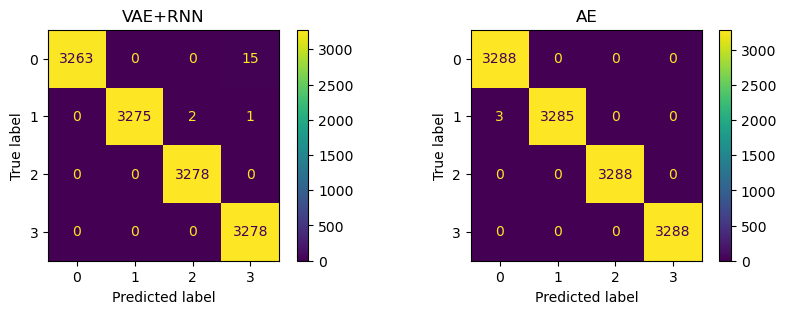

ROC Curve:


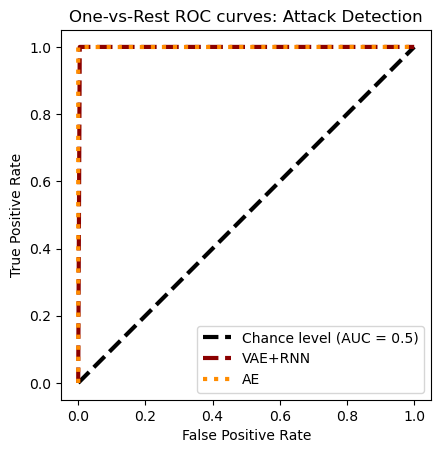

In [15]:
severity = 5
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.995424  0.997707      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.995445  1.000000  0.997717      3278

    accuracy                       0.998856     13112
   macro avg   0.998861  0.998856  0.998856     13112
weighted avg   0.998861  0.998856  0.998856     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


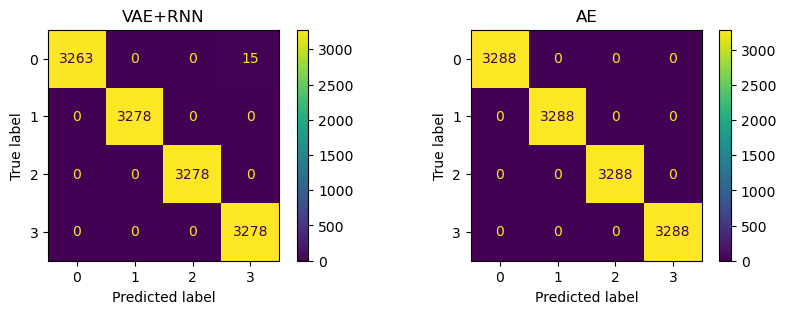

ROC Curve:


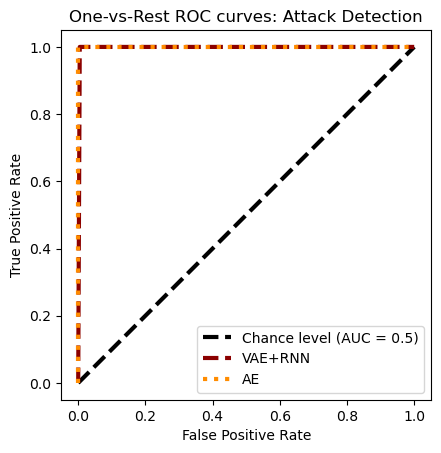

In [16]:
severity = 6
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.995424  0.997707      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.995445  1.000000  0.997717      3278

    accuracy                       0.998856     13112
   macro avg   0.998861  0.998856  0.998856     13112
weighted avg   0.998861  0.998856  0.998856     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


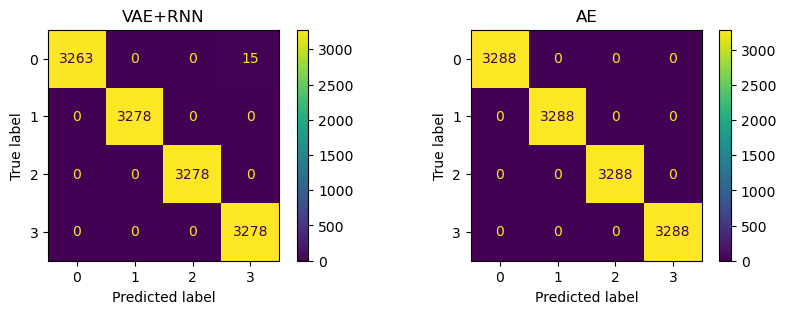

ROC Curve:


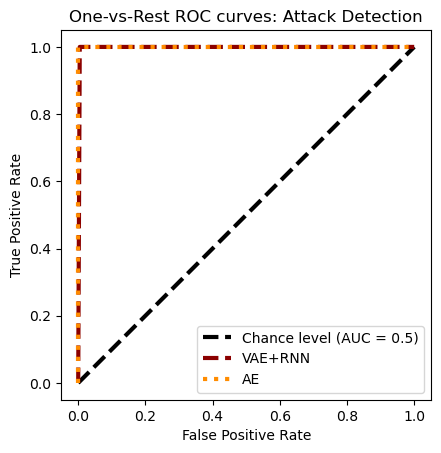

In [17]:
severity = 7
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.995424  0.997707      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.995445  1.000000  0.997717      3278

    accuracy                       0.998856     13112
   macro avg   0.998861  0.998856  0.998856     13112
weighted avg   0.998861  0.998856  0.998856     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


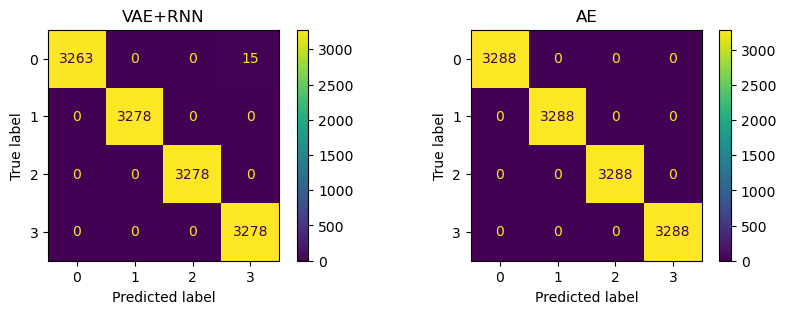

ROC Curve:


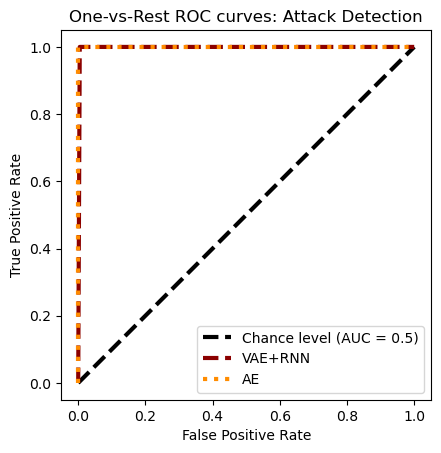

In [18]:
severity = 8
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.982831  0.995424  0.989088      3278
           1   1.000000  0.999085  0.999542      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.995369  0.983527  0.989412      3278

    accuracy                       0.994509     13112
   macro avg   0.994550  0.994509  0.994511     13112
weighted avg   0.994550  0.994509  0.994511     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  0.999696  0.999848      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999696  1.000000  0.999848      3288

    accuracy                       0.999924     13152
   macro avg   0.999924  0.999924  0.999924     13152
weighted avg   0.999924  0.999924  0.999924     13152

Confusion Matrix:


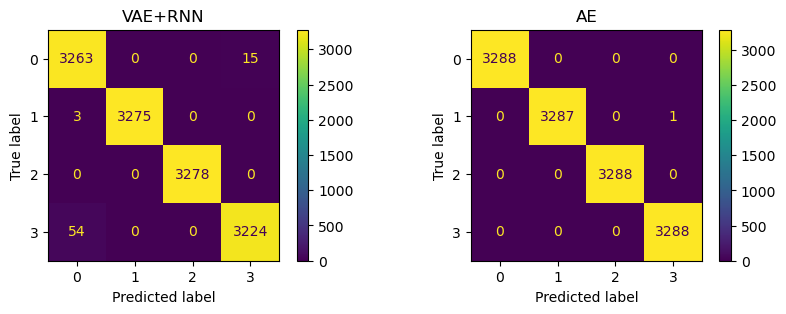

ROC Curve:


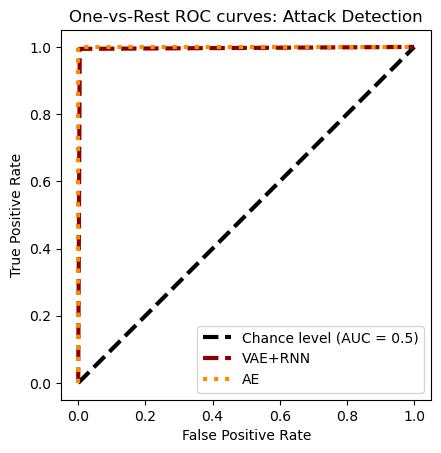

In [19]:
severity = 9
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

### **Confusion Matrix: Noise Level 5%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.993594  0.996787      3278
           1   1.000000  0.999390  0.999695      3278
           2   0.999695  1.000000  0.999847      3278
           3   0.993333  1.000000  0.996656      3278

    accuracy                       0.998246     13112
   macro avg   0.998257  0.998246  0.998246     13112
weighted avg   0.998257  0.998246  0.998246     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.998851  0.793491  0.884407      3288
           1   0.940991  0.999088  0.969169      3288
           2   0.990660  1.000000  0.995308      3288
           3   0.864879  0.981144  0.919350      3288

    accuracy                       0.943431     13152
   macro avg   0.948845  0.943431  0.942059     13152
weighted avg   0.948845  0.943431  0.942059     13152

Confusion Matrix:


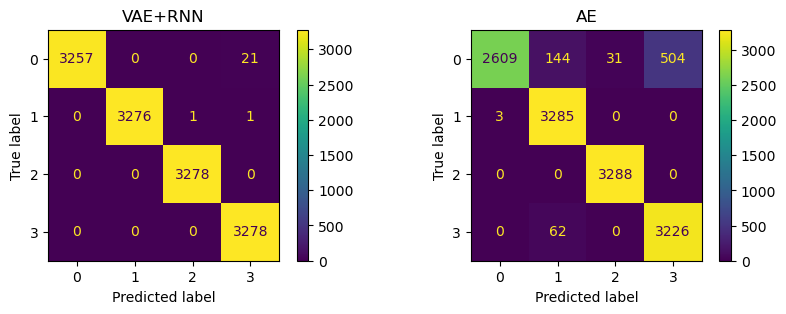

ROC Curve:


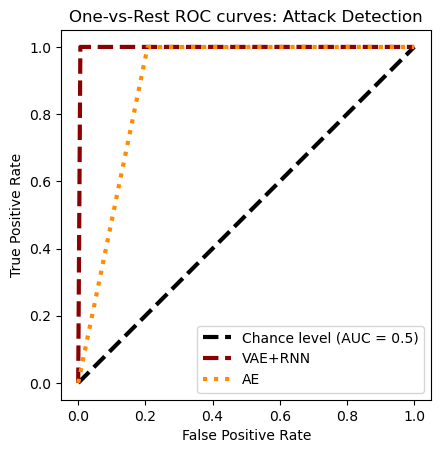

In [20]:
severity = 5
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.993594  0.996787      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.993634  1.000000  0.996807      3278

    accuracy                       0.998398     13112
   macro avg   0.998409  0.998398  0.998398     13112
weighted avg   0.998409  0.998398  0.998398     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.793491  0.884857      3288
           1   0.937821  1.000000  0.967913      3288
           2   0.990660  1.000000  0.995308      3288
           3   0.864443  0.977494  0.917499      3288

    accuracy                       0.942746     13152
   macro avg   0.948231  0.942746  0.941394     13152
weighted avg   0.948231  0.942746  0.941394     13152

Confusion Matrix:


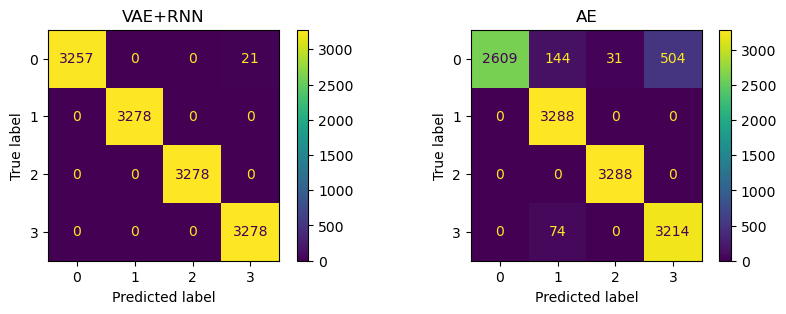

ROC Curve:


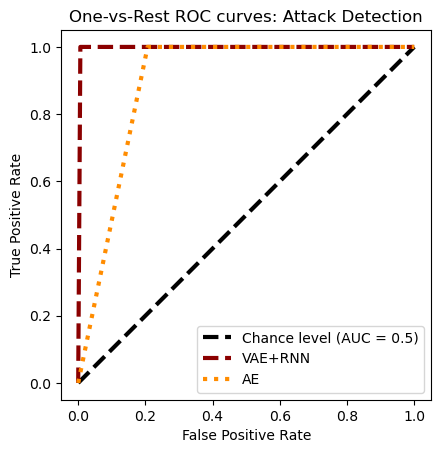

In [21]:
severity = 6
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.993594  0.996787      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.993634  1.000000  0.996807      3278

    accuracy                       0.998398     13112
   macro avg   0.998409  0.998398  0.998398     13112
weighted avg   0.998409  0.998398  0.998398     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.990133  0.793491  0.880972      3288
           1   0.927242  1.000000  0.962248      3288
           2   0.989765  1.000000  0.994856      3288
           3   0.861880  0.956509  0.906732      3288

    accuracy                       0.937500     13152
   macro avg   0.942255  0.937500  0.936202     13152
weighted avg   0.942255  0.937500  0.936202     13152

Confusion Matrix:


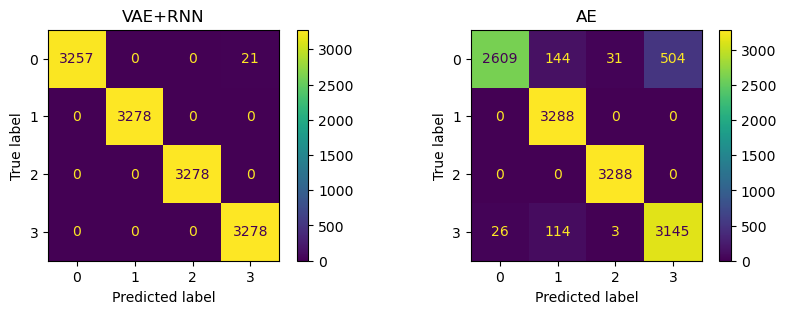

ROC Curve:


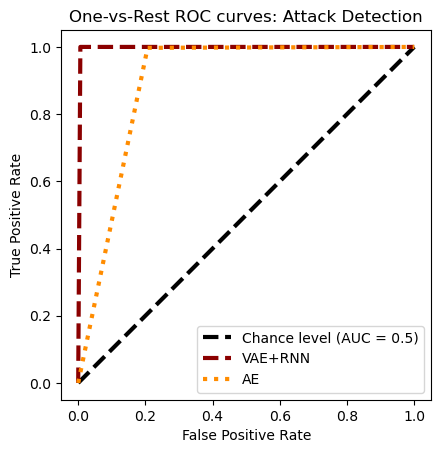

In [22]:
severity = 7
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.993594  0.996787      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.993634  1.000000  0.996807      3278

    accuracy                       0.998398     13112
   macro avg   0.998409  0.998398  0.998398     13112
weighted avg   0.998409  0.998398  0.998398     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.902144  0.793491  0.844337      3288
           1   0.910754  0.999392  0.953016      3288
           2   0.988575  1.000000  0.994255      3288
           3   0.848467  0.858273  0.853341      3288

    accuracy                       0.912789     13152
   macro avg   0.912485  0.912789  0.911237     13152
weighted avg   0.912485  0.912789  0.911237     13152

Confusion Matrix:


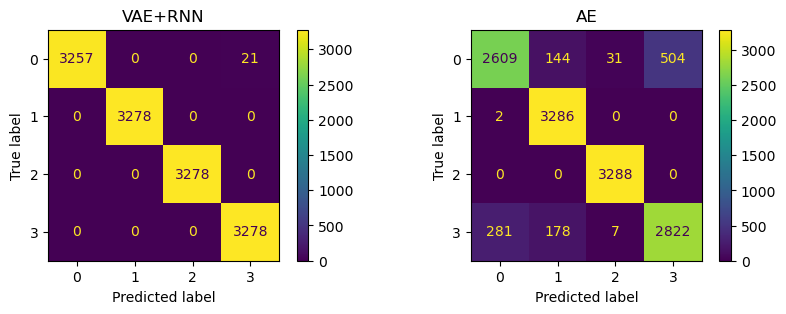

ROC Curve:


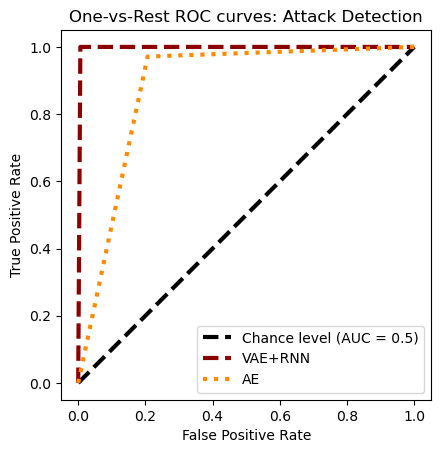

In [23]:
severity = 8
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.983394  0.993594  0.988467      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.993530  0.983832  0.988657      3278

    accuracy                       0.994204     13112
   macro avg   0.994231  0.994204  0.994205     13112
weighted avg   0.994231  0.994204  0.994205     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.762865  0.793491  0.777877      3288
           1   0.897145  0.936436  0.916369      3288
           2   0.987057  0.974148  0.980560      3288
           3   0.802291  0.745438  0.772820      3288

    accuracy                       0.862378     13152
   macro avg   0.862340  0.862378  0.861907     13152
weighted avg   0.862340  0.862378  0.861907     13152

Confusion Matrix:


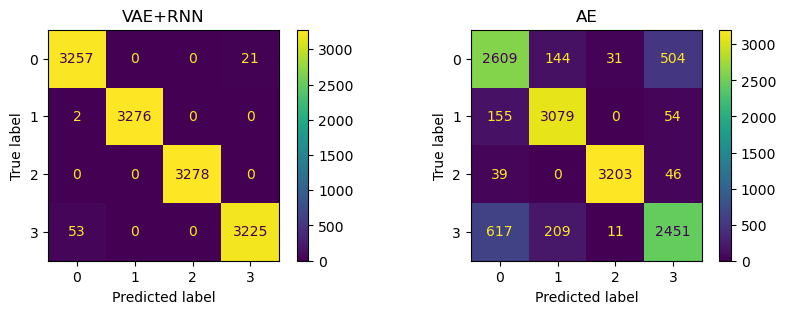

ROC Curve:


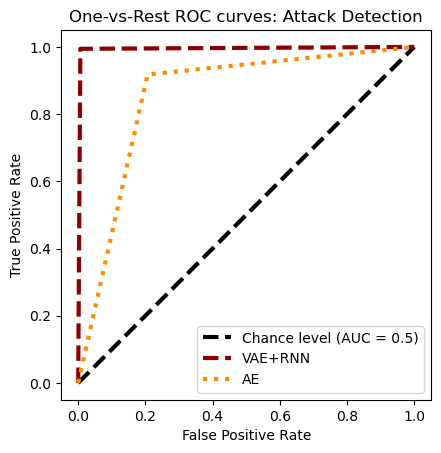

In [24]:
severity = 9
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

### **Confusion Matrix: Noise Level 10%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.995424  0.997707      3278
           1   1.000000  0.999390  0.999695      3278
           2   0.999695  1.000000  0.999847      3278
           3   0.995143  1.000000  0.997565      3278

    accuracy                       0.998703     13112
   macro avg   0.998709  0.998703  0.998704     13112
weighted avg   0.998709  0.998703  0.998704     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999083  0.994221  0.996646      3288
           1   0.999696  0.999088  0.999392      3288
           2   0.996666  1.000000  0.998330      3288
           3   0.997876  1.000000  0.998937      3288

    accuracy                       0.998327     13152
   macro avg   0.998330  0.998327  0.998326     13152
weighted avg   0.998330  0.998327  0.998326     13152

Confusion Matrix:


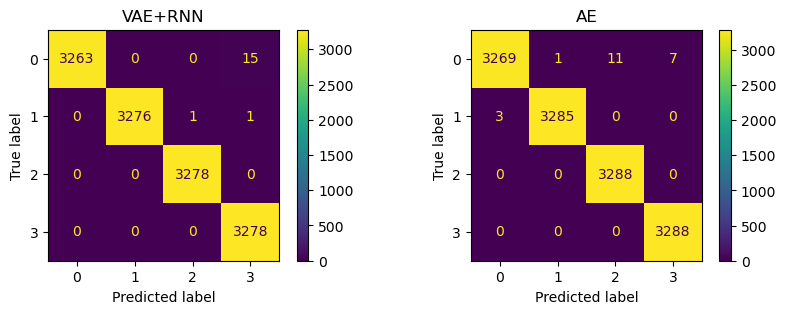

ROC Curve:


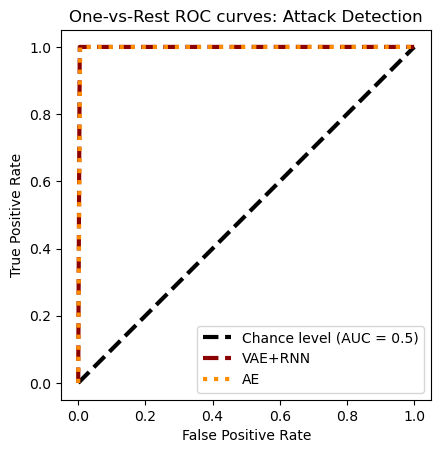

In [25]:
severity = 5
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.995424  0.997707      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.995445  1.000000  0.997717      3278

    accuracy                       0.998856     13112
   macro avg   0.998861  0.998856  0.998856     13112
weighted avg   0.998861  0.998856  0.998856     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.994221  0.997102      3288
           1   0.999088  1.000000  0.999544      3288
           2   0.994555  1.000000  0.997270      3288
           3   0.997870  0.997263  0.997566      3288

    accuracy                       0.997871     13152
   macro avg   0.997878  0.997871  0.997871     13152
weighted avg   0.997878  0.997871  0.997871     13152

Confusion Matrix:


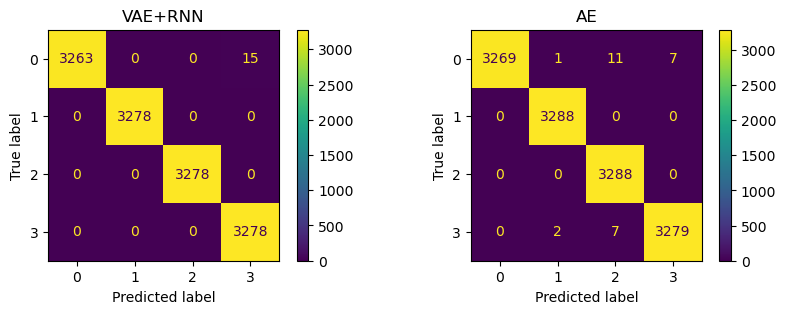

ROC Curve:


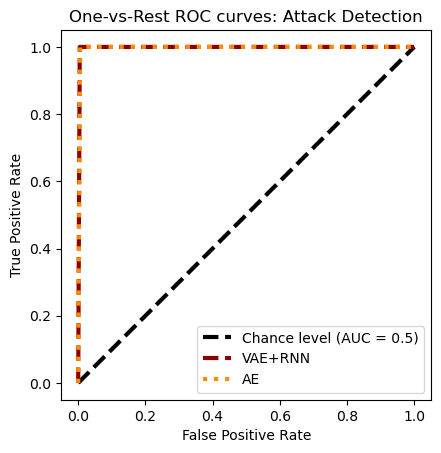

In [26]:
severity = 6
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.995424  0.997707      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.995445  1.000000  0.997717      3278

    accuracy                       0.998856     13112
   macro avg   0.998861  0.998856  0.998856     13112
weighted avg   0.998861  0.998856  0.998856     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999389  0.994221  0.996798      3288
           1   0.994255  1.000000  0.997119      3288
           2   0.989765  1.000000  0.994856      3288
           3   0.997847  0.986922  0.992355      3288

    accuracy                       0.995286     13152
   macro avg   0.995314  0.995286  0.995282     13152
weighted avg   0.995314  0.995286  0.995282     13152

Confusion Matrix:


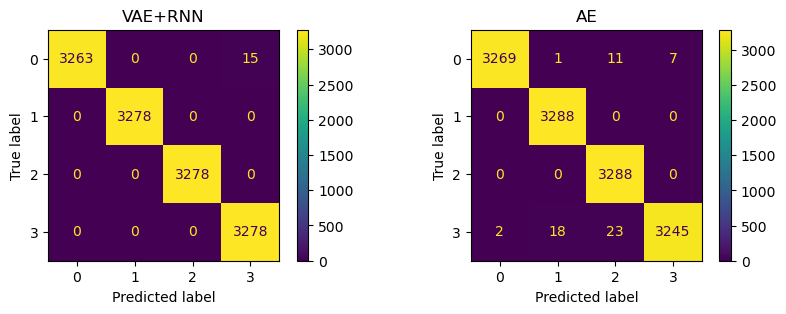

ROC Curve:


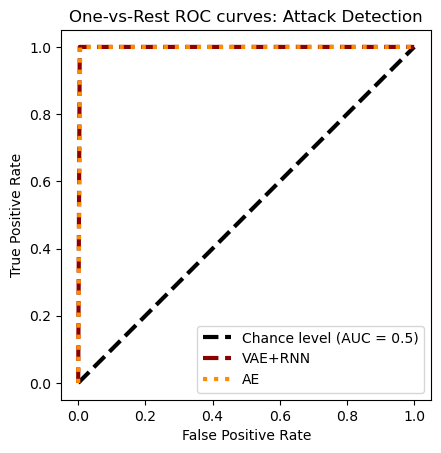

In [27]:
severity = 7
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.995424  0.997707      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.995445  1.000000  0.997717      3278

    accuracy                       0.998856     13112
   macro avg   0.998861  0.998856  0.998856     13112
weighted avg   0.998861  0.998856  0.998856     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.966017  0.994221  0.979916      3288
           1   0.980322  1.000000  0.990063      3288
           2   0.982079  1.000000  0.990958      3288
           3   0.997717  0.930353  0.962858      3288

    accuracy                       0.981144     13152
   macro avg   0.981534  0.981144  0.980949     13152
weighted avg   0.981534  0.981144  0.980949     13152

Confusion Matrix:


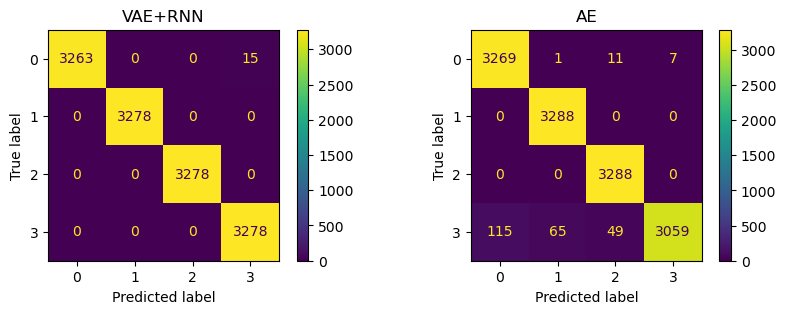

ROC Curve:


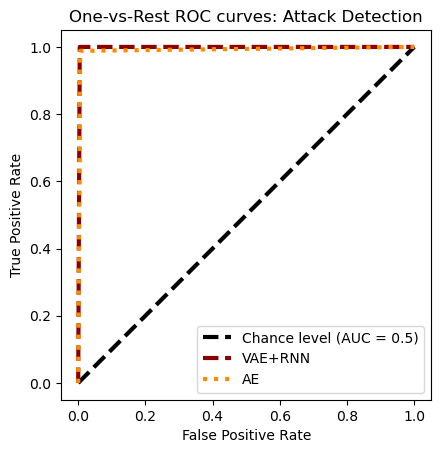

In [28]:
severity = 8
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.982831  0.995424  0.989088      3278
           1   1.000000  0.999085  0.999542      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.995369  0.983527  0.989412      3278

    accuracy                       0.994509     13112
   macro avg   0.994550  0.994509  0.994511     13112
weighted avg   0.994550  0.994509  0.994511     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.872431  0.994221  0.929353      3288
           1   0.964812  0.975669  0.970210      3288
           2   0.972206  1.000000  0.985907      3288
           3   0.970348  0.796229  0.874708      3288

    accuracy                       0.941530     13152
   macro avg   0.944949  0.941530  0.940045     13152
weighted avg   0.944949  0.941530  0.940045     13152

Confusion Matrix:


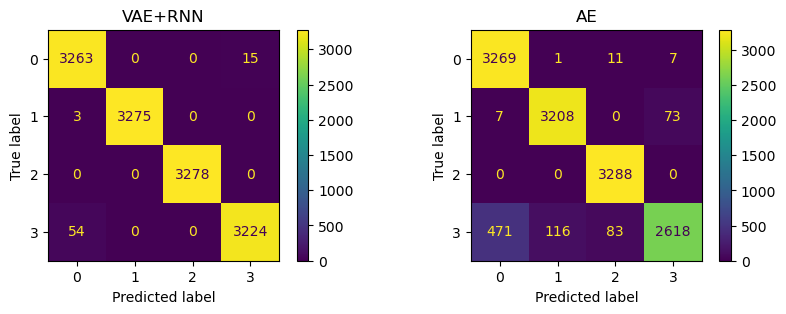

ROC Curve:


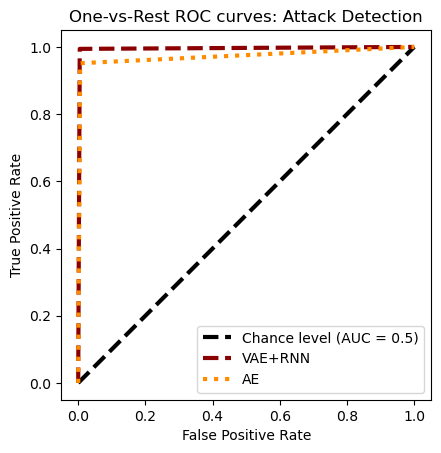

In [29]:
severity = 9
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

### **Confusion Matrix: Noise Level 20%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.993594  0.996787      3278
           1   1.000000  0.999390  0.999695      3278
           2   0.999695  1.000000  0.999847      3278
           3   0.993333  1.000000  0.996656      3278

    accuracy                       0.998246     13112
   macro avg   0.998257  0.998246  0.998246     13112
weighted avg   0.998257  0.998246  0.998246     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999085  0.996655  0.997868      3288
           1   0.987970  0.999088  0.993498      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.991180  0.995570      3288

    accuracy                       0.996731     13152
   macro avg   0.996764  0.996731  0.996734     13152
weighted avg   0.996764  0.996731  0.996734     13152

Confusion Matrix:


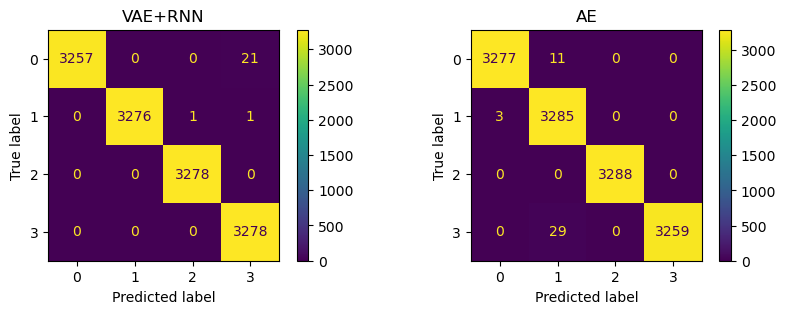

ROC Curve:


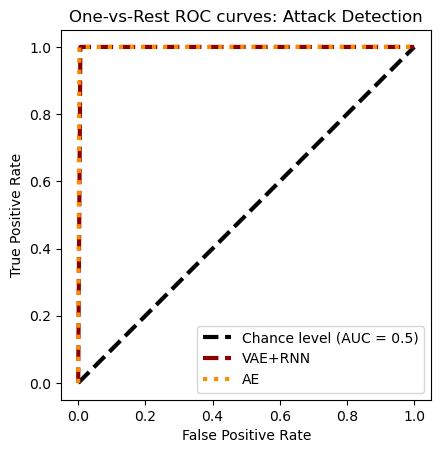

In [30]:
severity = 5
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.993594  0.996787      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.993634  1.000000  0.996807      3278

    accuracy                       0.998398     13112
   macro avg   0.998409  0.998398  0.998398     13112
weighted avg   0.998409  0.998398  0.998398     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.996655  0.998324      3288
           1   0.982372  1.000000  0.991108      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.985401  0.992647      3288

    accuracy                       0.995514     13152
   macro avg   0.995593  0.995514  0.995520     13152
weighted avg   0.995593  0.995514  0.995520     13152

Confusion Matrix:


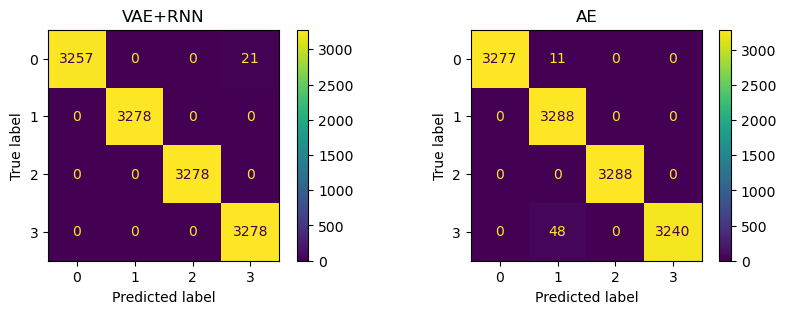

ROC Curve:


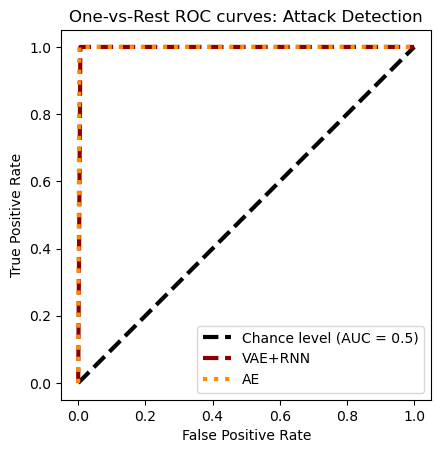

In [31]:
severity = 6
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.993594  0.996787      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.993634  1.000000  0.996807      3278

    accuracy                       0.998398     13112
   macro avg   0.998409  0.998398  0.998398     13112
weighted avg   0.998409  0.998398  0.998398     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.996655  0.998324      3288
           1   0.968768  1.000000  0.984136      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.971107  0.985342      3288

    accuracy                       0.991940     13152
   macro avg   0.992192  0.991940  0.991951     13152
weighted avg   0.992192  0.991940  0.991951     13152

Confusion Matrix:


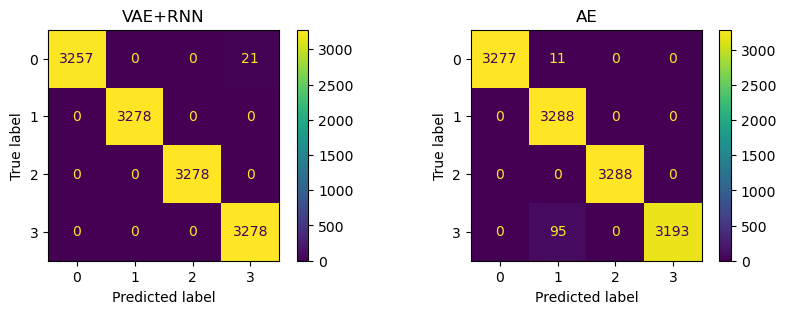

ROC Curve:


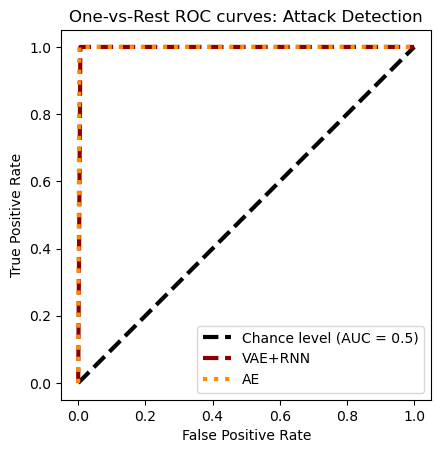

In [32]:
severity = 7
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.993594  0.996787      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.993634  1.000000  0.996807      3278

    accuracy                       0.998398     13112
   macro avg   0.998409  0.998398  0.998398     13112
weighted avg   0.998409  0.998398  0.998398     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.996655  0.998324      3288
           1   0.948644  1.000000  0.973645      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.949209  0.973943      3288

    accuracy                       0.986466     13152
   macro avg   0.987161  0.986466  0.986478     13152
weighted avg   0.987161  0.986466  0.986478     13152

Confusion Matrix:


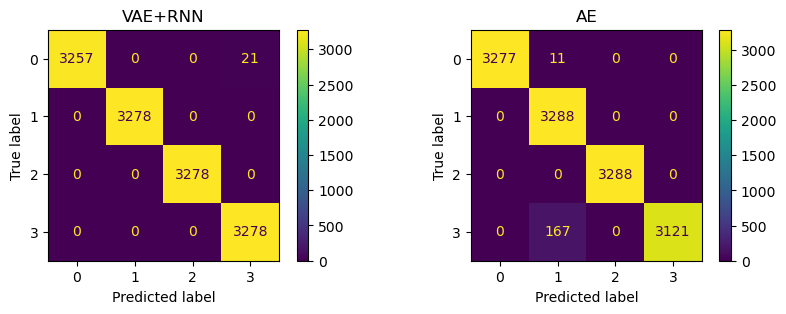

ROC Curve:


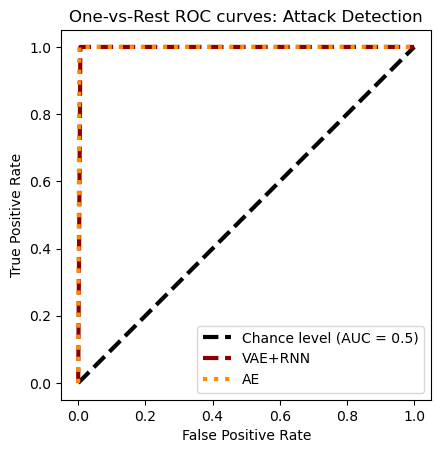

In [33]:
severity = 8
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.983394  0.993594  0.988467      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.993530  0.983832  0.988657      3278

    accuracy                       0.994204     13112
   macro avg   0.994231  0.994204  0.994205     13112
weighted avg   0.994231  0.994204  0.994205     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.997565  0.996655  0.997109      3288
           1   0.927765  1.000000  0.962529      3288
           2   1.000000  0.980535  0.990172      3288
           3   0.979671  0.923358  0.950681      3288

    accuracy                       0.975137     13152
   macro avg   0.976250  0.975137  0.975123     13152
weighted avg   0.976250  0.975137  0.975123     13152

Confusion Matrix:


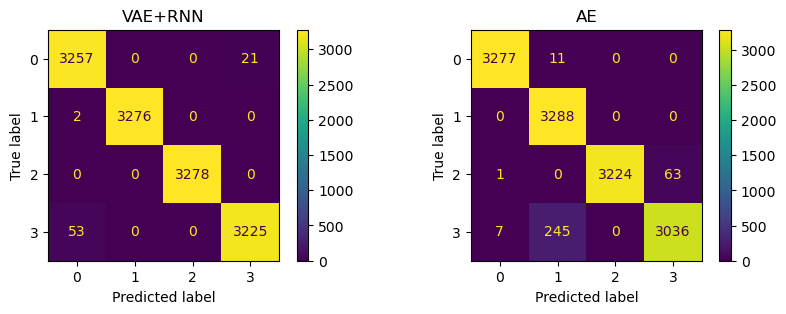

ROC Curve:


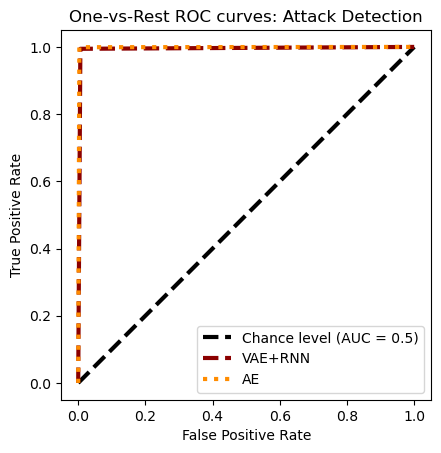

In [34]:
severity = 9
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

### **Confusion Matrix: Noise Level 50%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.994814  0.997400      3278
           1   1.000000  0.999390  0.999695      3278
           2   0.999695  1.000000  0.999847      3278
           3   0.994539  1.000000  0.997262      3278

    accuracy                       0.998551     13112
   macro avg   0.998558  0.998551  0.998551     13112
weighted avg   0.998558  0.998551  0.998551     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999074  0.984185  0.991573      3288
           1   0.915297  0.999088  0.955358      3288
           2   0.996666  1.000000  0.998330      3288
           3   1.000000  0.920012  0.958340      3288

    accuracy                       0.975821     13152
   macro avg   0.977759  0.975821  0.975900     13152
weighted avg   0.977759  0.975821  0.975900     13152

Confusion Matrix:


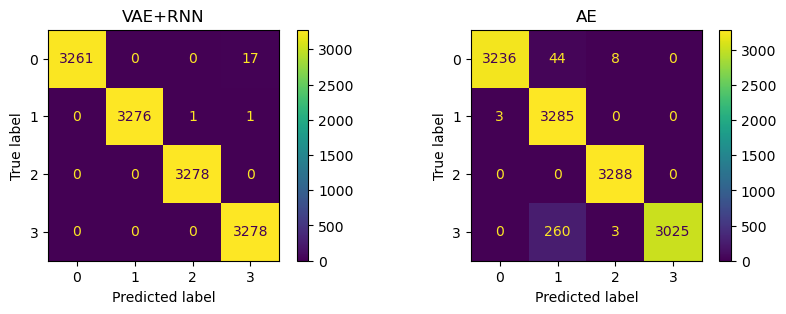

ROC Curve:


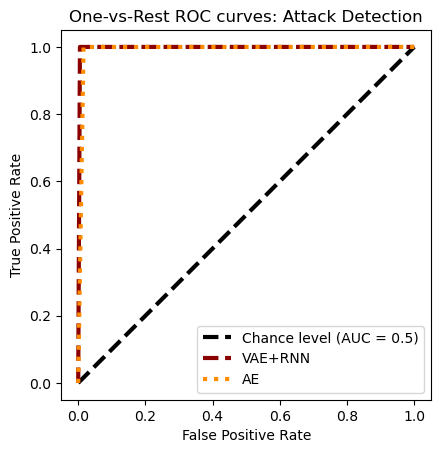

In [35]:
severity = 5
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.994814  0.997400      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.994841  1.000000  0.997414      3278

    accuracy                       0.998703     13112
   macro avg   0.998710  0.998703  0.998703     13112
weighted avg   0.998710  0.998703  0.998703     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.984185  0.992029      3288
           1   0.902058  1.000000  0.948507      3288
           2   0.990361  1.000000  0.995157      3288
           3   1.000000  0.897506  0.945985      3288

    accuracy                       0.970423     13152
   macro avg   0.973105  0.970423  0.970420     13152
weighted avg   0.973105  0.970423  0.970420     13152

Confusion Matrix:


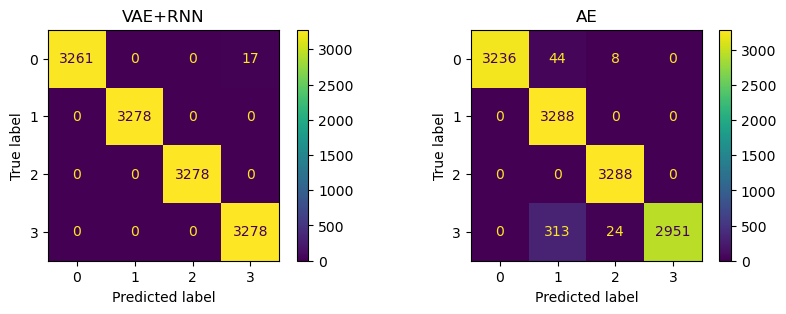

ROC Curve:


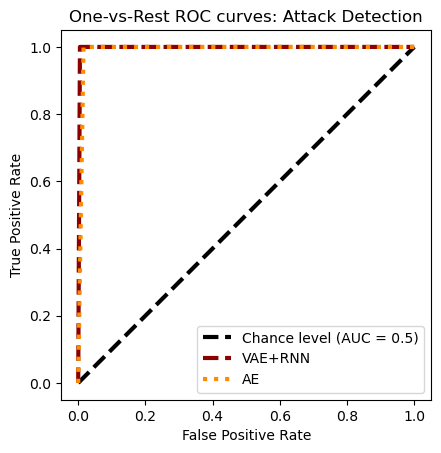

In [36]:
severity = 6
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.994814  0.997400      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.994841  1.000000  0.997414      3278

    accuracy                       0.998703     13112
   macro avg   0.998710  0.998703  0.998703     13112
weighted avg   0.998710  0.998703  0.998703     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.984185  0.992029      3288
           1   0.882922  1.000000  0.937821      3288
           2   0.974511  1.000000  0.987091      3288
           3   1.000000  0.857056  0.923027      3288

    accuracy                       0.960310     13152
   macro avg   0.964358  0.960310  0.959992     13152
weighted avg   0.964358  0.960310  0.959992     13152

Confusion Matrix:


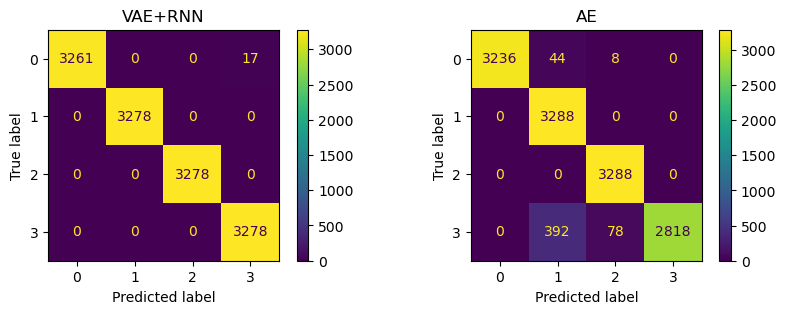

ROC Curve:


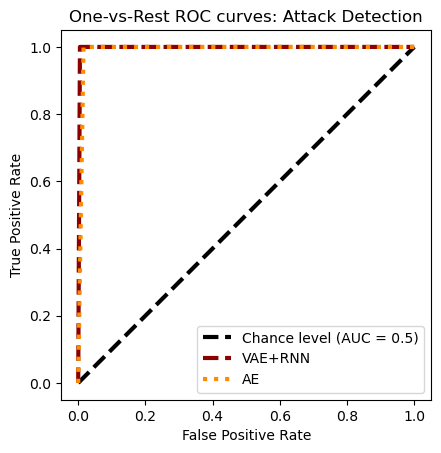

In [37]:
severity = 7
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.994814  0.997400      3278
           1   1.000000  1.000000  1.000000      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.994841  1.000000  0.997414      3278

    accuracy                       0.998703     13112
   macro avg   0.998710  0.998703  0.998703     13112
weighted avg   0.998710  0.998703  0.998703     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  0.984185  0.992029      3288
           1   0.858486  1.000000  0.923855      3288
           2   0.953583  0.999696  0.976095      3288
           3   0.999621  0.802311  0.890164      3288

    accuracy                       0.946548     13152
   macro avg   0.952922  0.946548  0.945536     13152
weighted avg   0.952922  0.946548  0.945536     13152

Confusion Matrix:


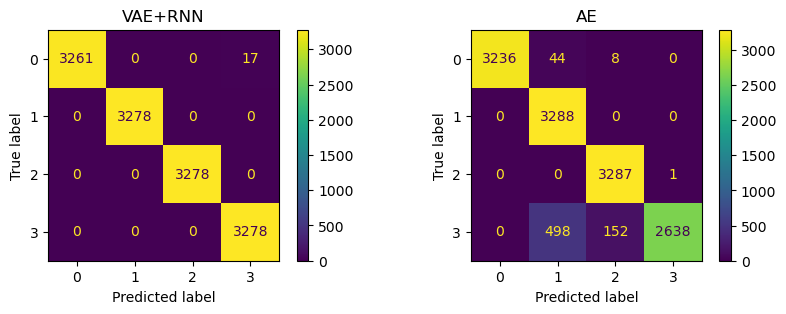

ROC Curve:


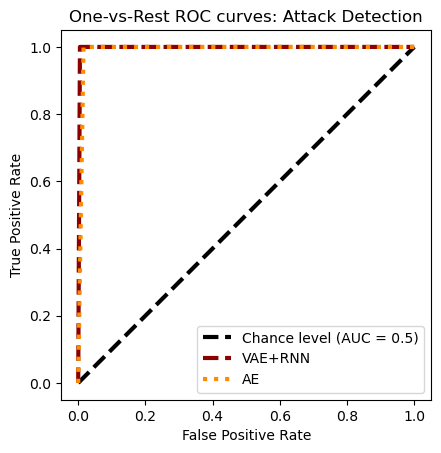

In [38]:
severity = 8
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.
classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.983414  0.994814  0.989081      3278
           1   1.000000  0.999390  0.999695      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.994756  0.983832  0.989264      3278

    accuracy                       0.994509     13112
   macro avg   0.994543  0.994509  0.994510     13112
weighted avg   0.994543  0.994509  0.994510     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.995080  0.984185  0.989602      3288
           1   0.824802  0.950730  0.883300      3288
           2   0.925814  0.933698  0.929740      3288
           3   0.873658  0.742397  0.802696      3288

    accuracy                       0.902752     13152
   macro avg   0.904839  0.902752  0.901335     13152
weighted avg   0.904839  0.902752  0.901335     13152

Confusion Matrix:


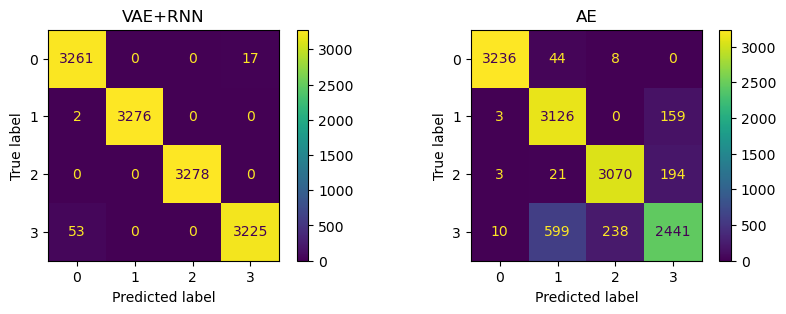

ROC Curve:


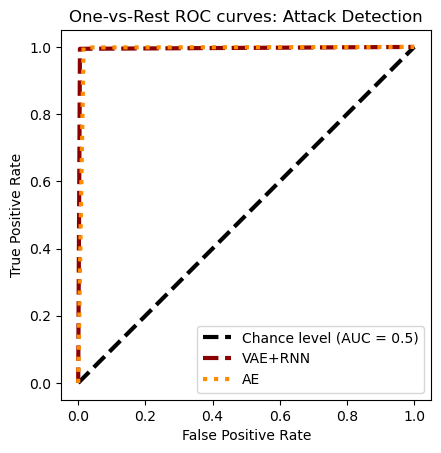

In [39]:
severity = 9
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.savefig(f'./img/cm_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.savefig(f'./img/roc_nl{level}_as{severity}.pdf',
            format='pdf',
            dpi=1200,
            bbox_inches='tight')
plt.show()

## **Quantiles**

In [40]:
q = torch.tensor([0.025, 0.975])
x_ax = ['0%', '%5', '%10', '%20', '50%']

### **Quantiles: Attack Severity 5**

In [41]:
severity = 5
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 37.72it/s]


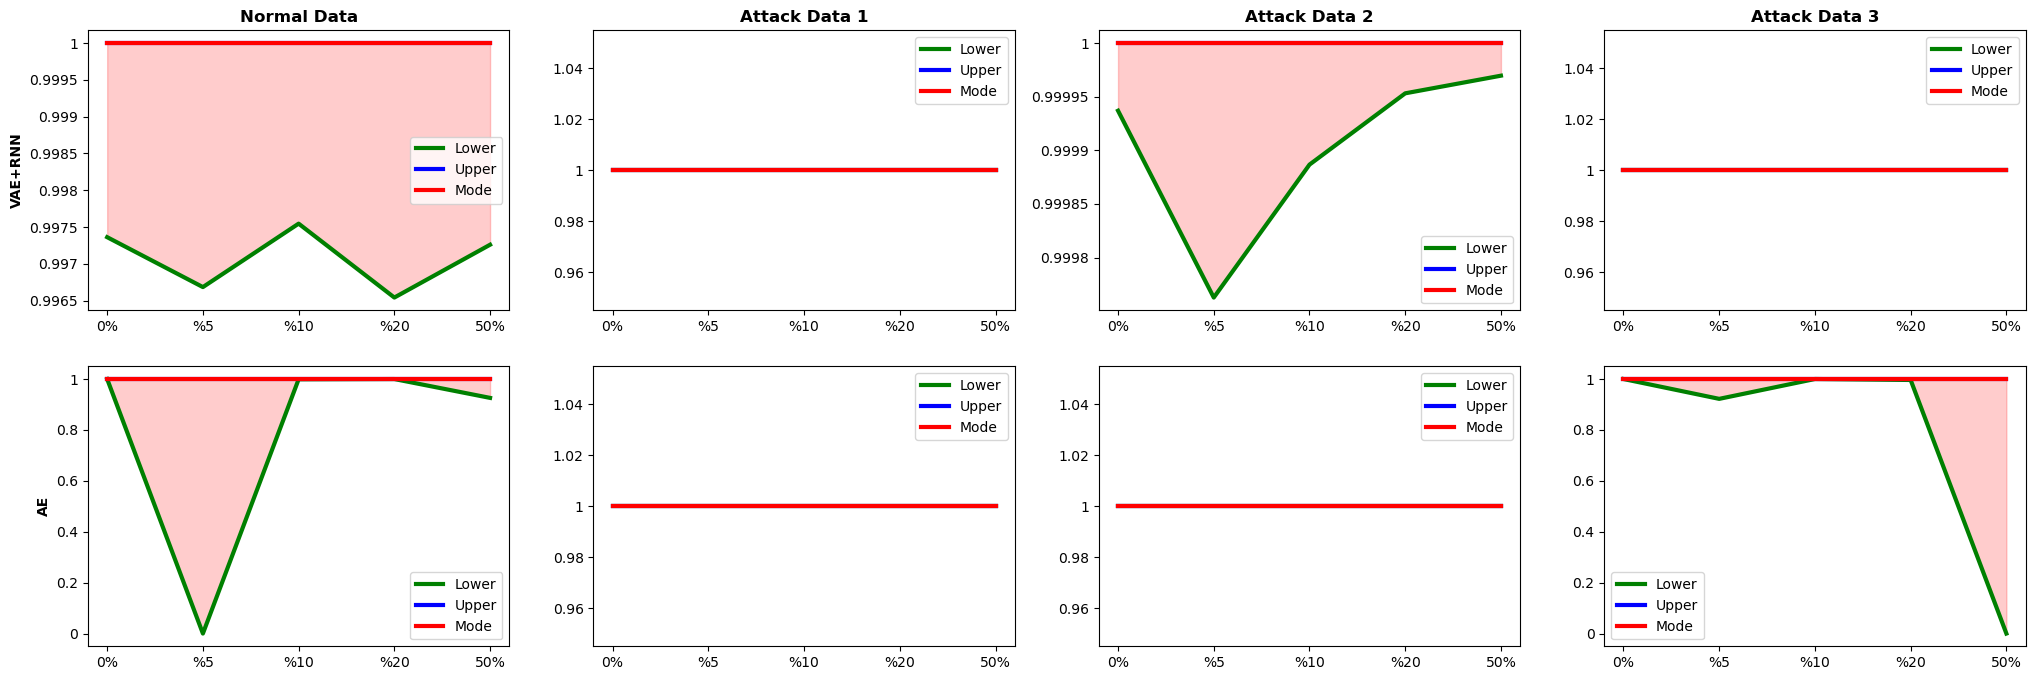

In [42]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%g'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### **Quantiles: Attack Severity 6**

In [43]:
severity = 6
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 30.91it/s]


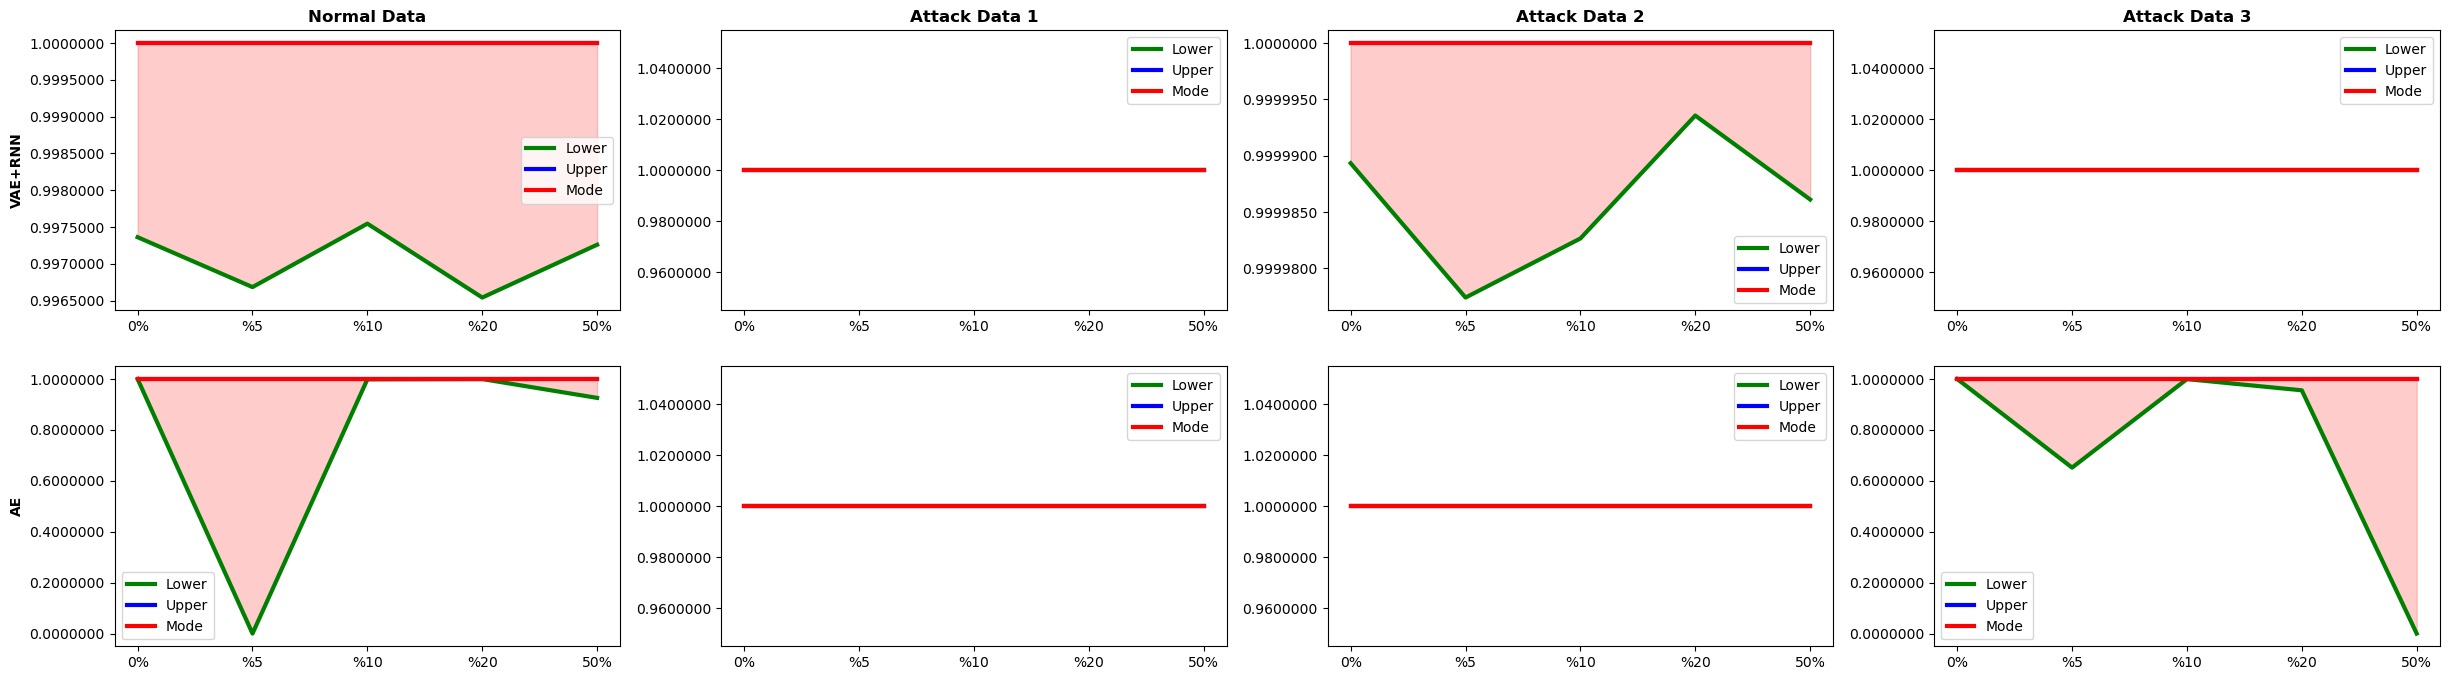

In [44]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.7f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### **Quantiles: Attack Severity 7**

In [45]:
severity = 7
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 17.43it/s]


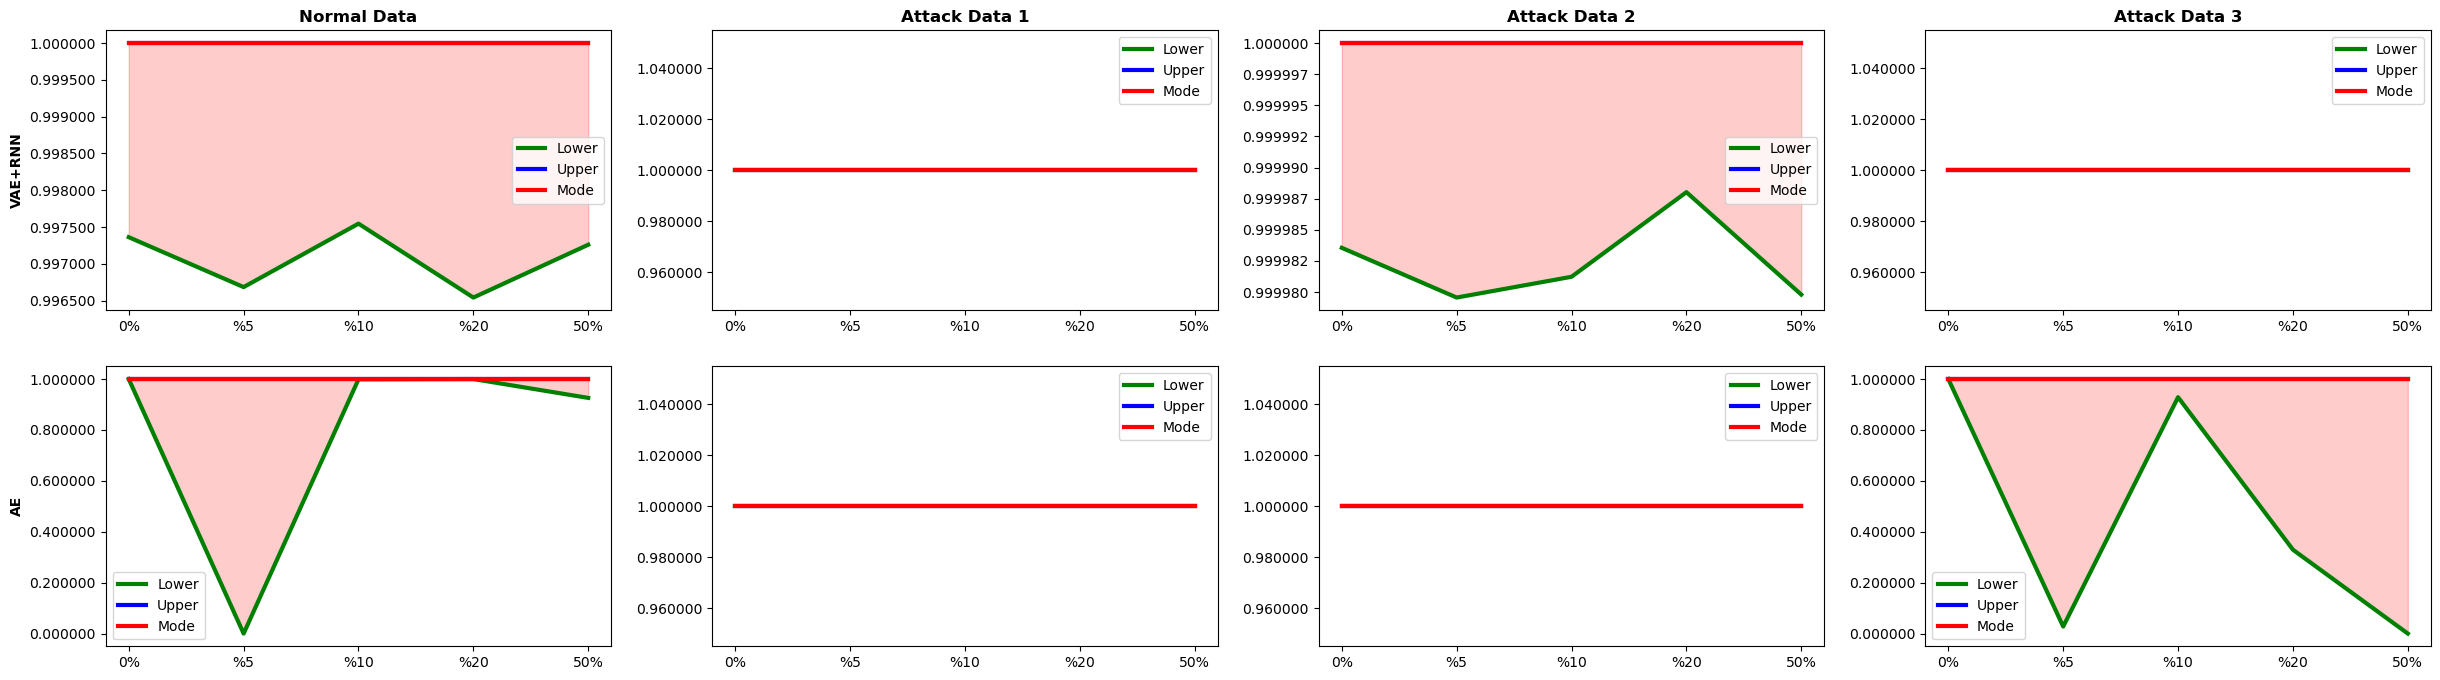

In [46]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.6f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### **Quantiles: Attack Severity 8**

In [47]:
severity = 8
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 18.01it/s]


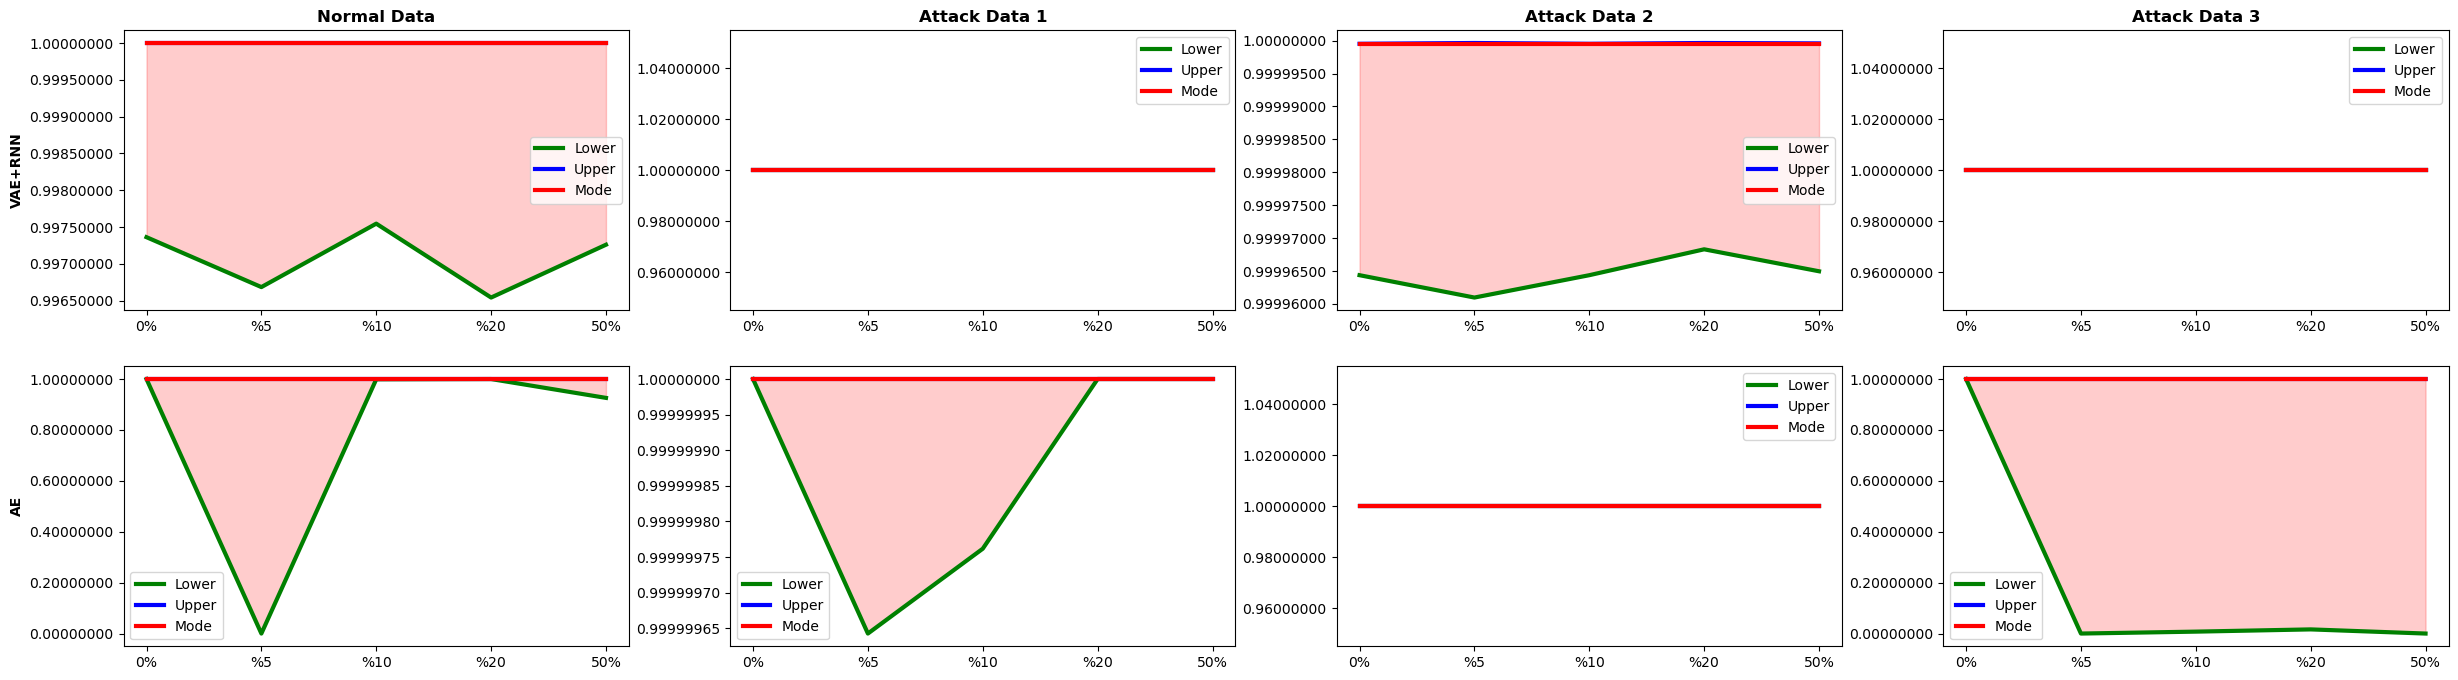

In [48]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.8f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

### **Quantiles: Attack Severity 9**

In [49]:
severity = 9
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 20.66it/s]


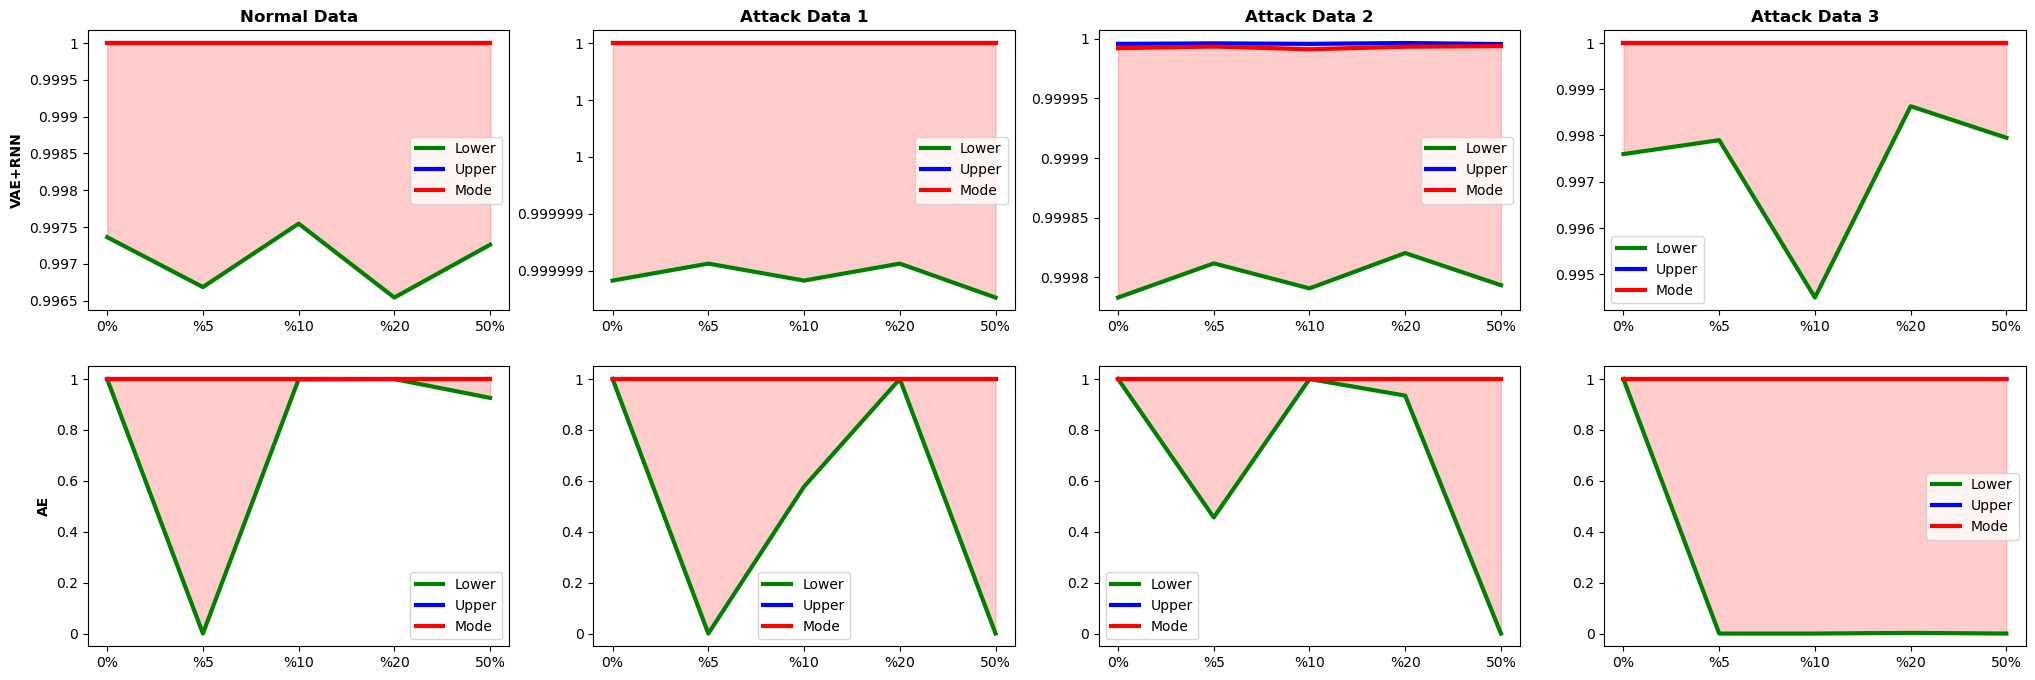

In [50]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%g'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.savefig(f'./img/qt_as{severity}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## **Detection-Localozation Accuracy**

In [51]:
detection, localization = defaultdict(list), defaultdict(list)
for k in pred.keys():
    for severity in range(5,10):
        for level in noise_levels:
            pp = torch.argmax(pred[k][level,severity], dim=1).numpy()
            yy = torch.argmax(y[k], dim=1).numpy()
            localization[k, severity].append(metrics.accuracy_score(yy, pp))
            yy[yy>0] = 1
            pp[pp>0] = 1
            detection[k, severity].append(metrics.accuracy_score(yy,pp))

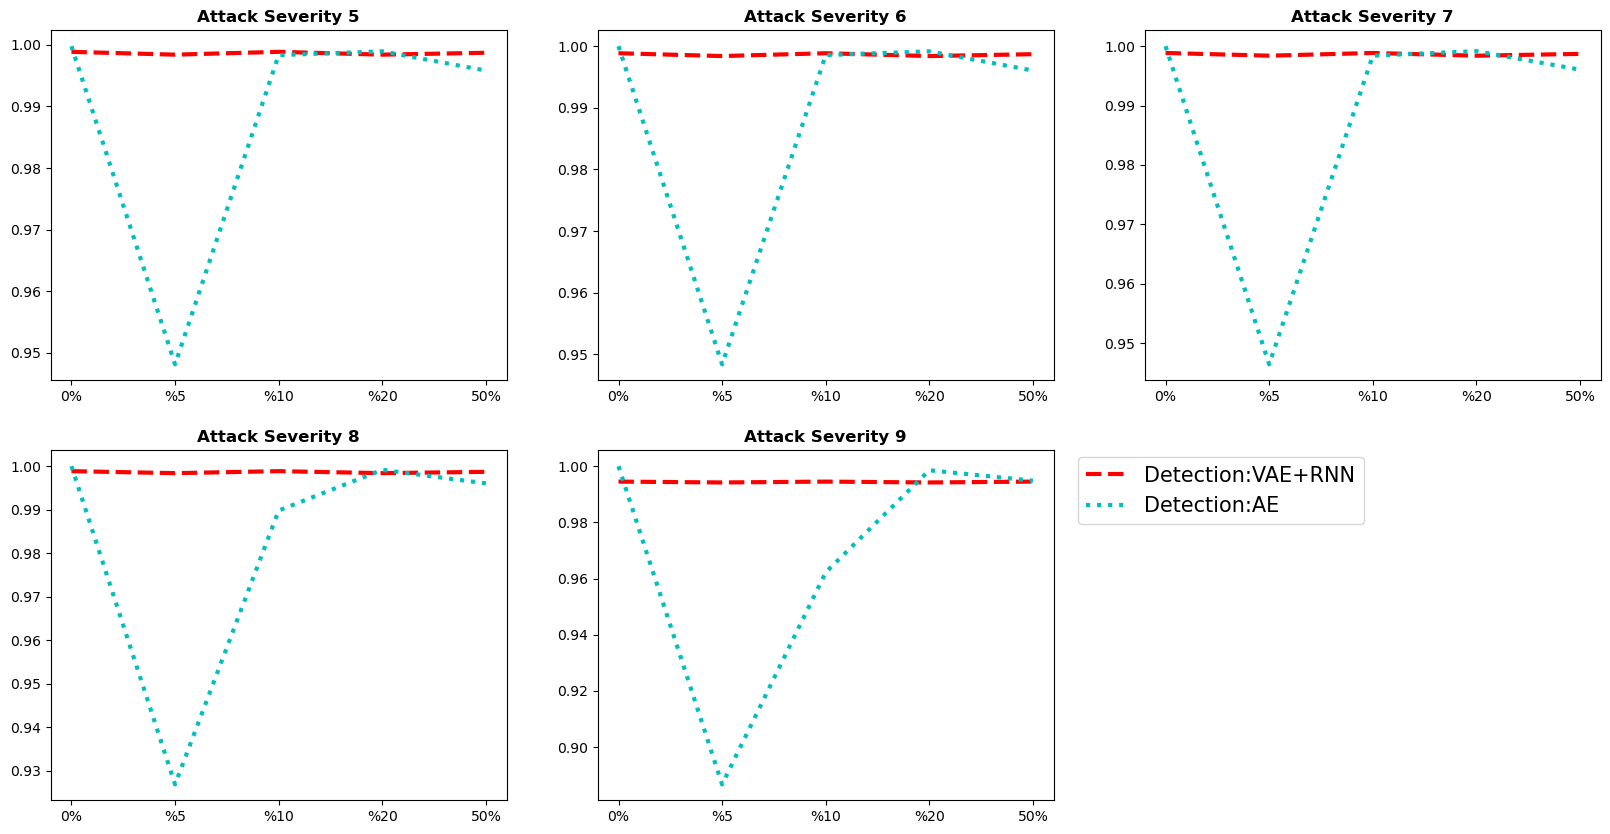

In [52]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
x_ax = ['0%', '%5', '%10', '%20', '50%']
fig, ax = plt.subplots(2,3, figsize=(20,10))
fig.delaxes(ax[1,2])
for s in severity:
    i = 0 if s < 8 else 1
    j = 0 if s < 8 else 3
    ax[i,s-5-j].plot(x, detection['vae',s], label='Detection:VAE+RNN', lw=3, linestyle="dashed", color='r')
    ax[i,s-5-j].plot(x, detection['ae',s], label='Detection:AE', lw=3, linestyle=':', color='c')
    ax[i,s-5-j].set(xticks=x, xticklabels=x_ax)
    ax[i,s-5-j].set_title(f'Attack Severity {s}', fontweight='bold')
ax[1,1].legend(prop={'size': 15}, bbox_to_anchor=(1.03, 1.01))
plt.savefig('./img/d.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

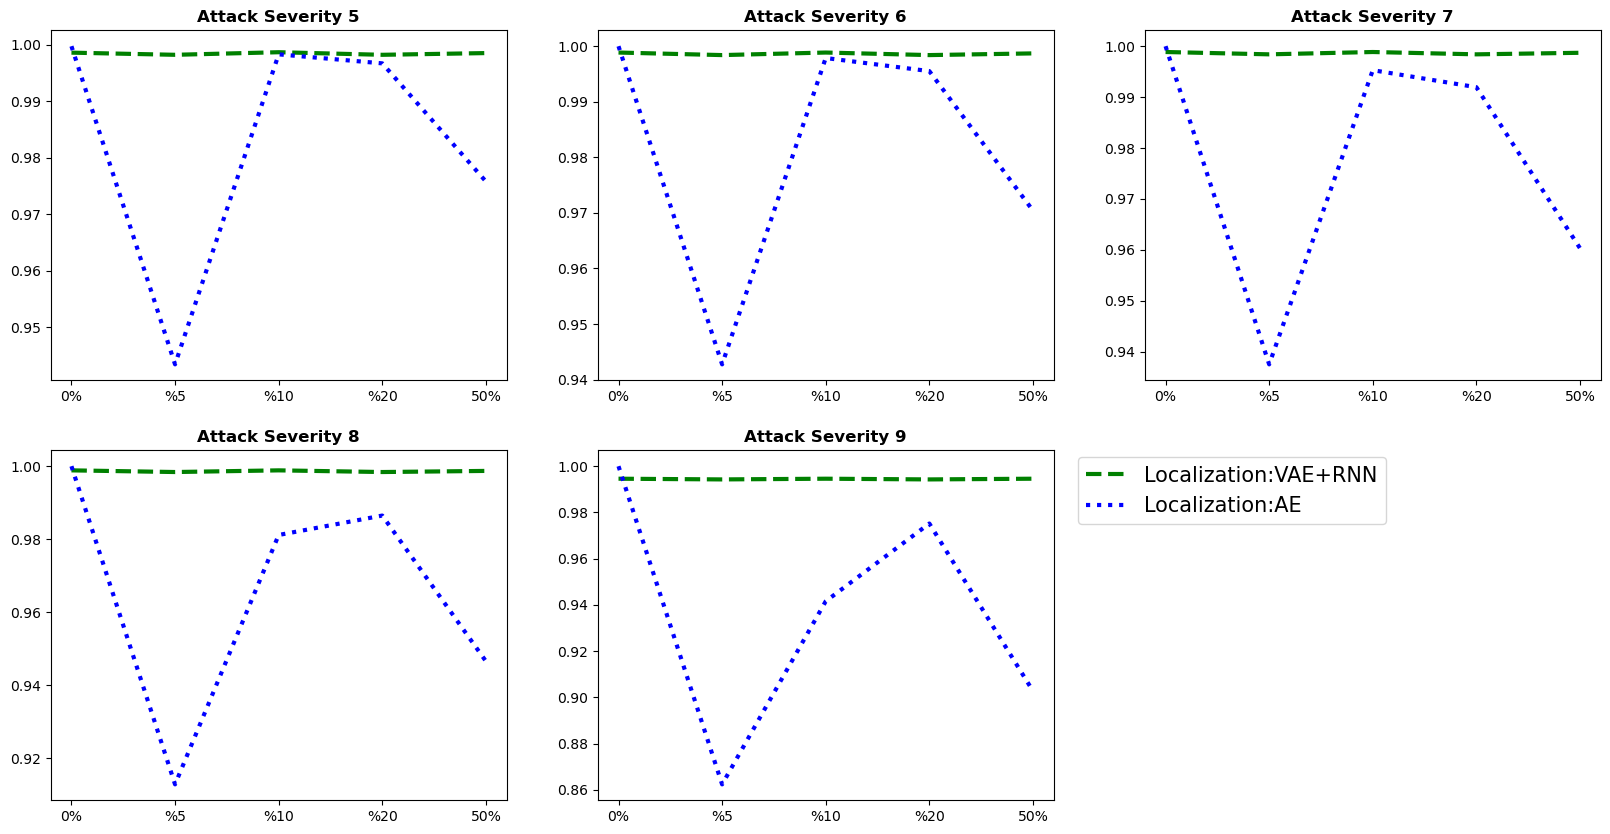

In [53]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
x_ax = ['0%', '%5', '%10', '%20', '50%']
fig, ax = plt.subplots(2,3, figsize=(20,10))
fig.delaxes(ax[1,2])
for s in severity:
    i = 0 if s < 8 else 1
    j = 0 if s < 8 else 3
    ax[i,s-5-j].plot(x, localization['vae',s], label='Localization:VAE+RNN', lw=3, linestyle="dashed", color='g')
    ax[i,s-5-j].plot(x, localization['ae',s], label='Localization:AE', lw=3, linestyle=':', color='b')
    ax[i,s-5-j].set(xticks=x, xticklabels=x_ax)
    ax[i,s-5-j].set_title(f'Attack Severity {s}', fontweight='bold')
ax[1,1].legend(prop={'size': 15}, bbox_to_anchor=(1.03, 1.01))
plt.savefig('./img/l.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()